In [197]:
%matplotlib inline
from brian2 import *
# clear_cache('cython')
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

# Default values

In [14]:
v_rest = -70*mV
v_reset = -65*mV
v_fire = -50*mV
R = 10.*Mohm
tau_m = 8.*ms
t_refrac = 2.0*ms

# 1.1 : minimal current

In [16]:
### According to eqn 1.7, the minimal current should be such that v_rest + R I_minimal = v_fire

I_minimal_theory = (v_fire - v_rest)/R
I_minimal_theory

2. * namp

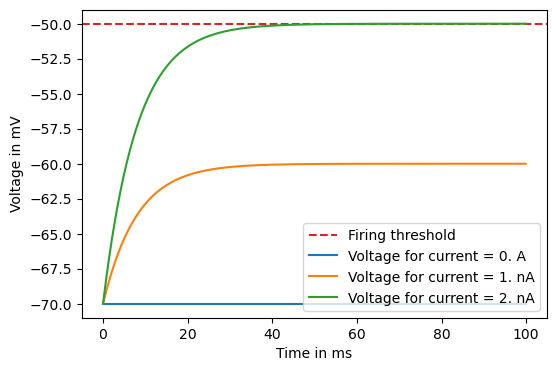

In [62]:
### Actual simulation; instead of single run, we will use three different current values, approaching the minimal current

start_scope()

n = 3
eqs = '''
dv/dt = - (v - v_rest)/tau_m + R*I/tau_m : volt (unless refractory)
I : amp
''' 
group = NeuronGroup(n, eqs, threshold='v > -50*mV', reset='v = -65*mV',
                    refractory=t_refrac, method='exact')
statemon = StateMonitor(group, 'v', record=True)
group.v = v_rest 
group.I = 'I_minimal_theory * i/(n-1)' 

spikemon = SpikeMonitor(group)

run(100*ms)

fig,ax = plt.subplots(figsize=(6, 4))

ax.axhline(v_fire/mV, ls = "--", color = "tab:red", label="Firing threshold")

for i in range(n):
    ax.plot(statemon.t/ms, statemon.v[i]/mV,label=f"Voltage for current = {I_minimal_theory * i/(n-1)}")

ax.set_xlabel("Time in ms")
ax.set_ylabel("Voltage in mV")
ax.legend(loc = 'lower right')

plt.show()


# 1.2 f-I Curve

WARNING    'i' is an internal variable of group 'neurongroup_3', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


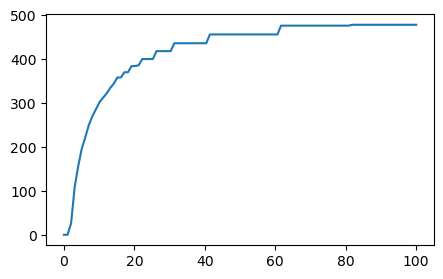

In [71]:
start_scope()

n = 100
duration = 500*ms
eqs = '''
dv/dt = - (v - v_rest)/tau_m + R*I/tau_m : volt (unless refractory)
I : amp
''' 
group = NeuronGroup(n, eqs, threshold='v > -50*mV', reset='v = -65*mV',
                    refractory=t_refrac, method='exact')
statemon = StateMonitor(group, 'v', record=True)
group.v = v_rest 
group.I = '100*nA * i/(n-1)' 

spikemon = SpikeMonitor(group)

run(duration)

fig,ax = plt.subplots(figsize=(5, 3))

ax.plot(group.I/nA, spikemon.count / duration)

plt.show()

In [74]:
### Theoretically, I feel like only the refractory period will limit the spikes ? 
### Like, its possible to trigger almost instantaneously after the refratory period is over, if the current is large enough ?

theoretical_max_freq = 1/t_refrac
theoretical_max_freq

0.5 * khertz

# 1.3 “Experimentally” estimate the parameters of a LIF neuron

In [137]:
rng = np.random.default_rng(100)

v_rest = rng.integers(low=-80, high=-60)*mV
v_reset = rng.integers(low=-80, high=-60)*mV
v_fire = rng.integers(low=-50, high=-40)*mV
R = 10*rng.random()*Mohm
tau_m = 100*rng.random()*ms
t_refrac = 5*rng.random()*ms

In [117]:
threshold_str = f"v > {v_fire/mV}*mV"
reset_str = f"v = {v_reset/mV}*mV"

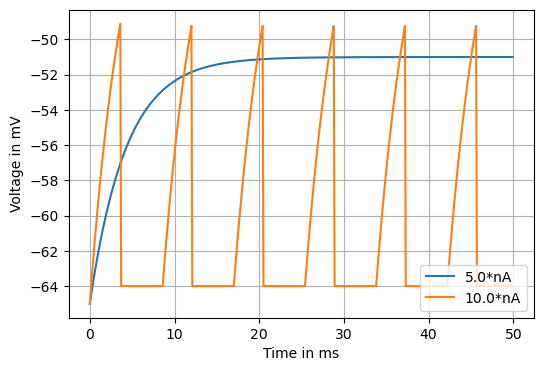

In [133]:
start_scope()

n = 2
eqs = '''
dv/dt = - (v - v_rest)/tau_m + R*I/tau_m : volt (unless refractory)
I : amp
''' 
group = NeuronGroup(n, eqs, threshold=threshold_str, reset=reset_str,
                    refractory=t_refrac, method='exact')
statemon = StateMonitor(group, 'v', record=True)
group.v = v_rest 
group.I = '10*nA*(i+1)/n'

spikemon = SpikeMonitor(group)

run(50*ms)

fig,ax = plt.subplots(figsize=(6, 4))

for i in range(n):
    ax.plot(statemon.t/ms, statemon.v[i]/mV, label=f'{10*(i+1)/n}*nA')

ax.set_xlabel("Time in ms")
ax.set_ylabel("Voltage in mV")
ax.legend(loc = 'lower right')

ax.grid()

plt.show()

In [139]:
#### Approx values from above graphs

v_rest_approx = -65*mV  ### Starting point of curves
v_reset_approx = -64*mV  ### refractory gap value
v_fire_approx = -50*mV  ### Topmost point
t_refrac_approx = 5*ms  ### gap size
v_flat_approx = -51*mV  ### Tapering flat portion for the 5*nA curve
R_approx = (v_flat_approx - v_rest_approx)/(5*nA)   ### u_final = u_rest + R I 

tau_m_approx = 5*ms ### Looking at the exponential curve for 5*nA and trying to estimate the point of 63% change 

v_rest_approx, v_reset_approx, v_fire_approx, R_approx, tau_m_approx, t_refrac_approx

(-65. * mvolt,
 -64. * mvolt,
 -50. * mvolt,
 2.8 * Mohm,
 5. * msecond,
 5. * msecond)

In [138]:
#### Actual values 

v_rest, v_reset, v_fire, R, tau_m, t_refrac

(-65. * mvolt,
 -64. * mvolt,
 -49. * mvolt,
 2.88863242 * Mohm,
 4.29515707 * msecond,
 4.86827198 * msecond)

# 1.4 Sinusoidal input current

In [170]:
defaultclock.dt = 0.01*ms
v_rest = -70*mV
v_reset = -65*mV
v_fire = -50*mV
R = 10.*Mohm
tau_m = 8.*ms
t_refrac = 2.0*ms

In [217]:
start_scope()

I_amp = 2.5*nA
I_0 = 0*nA

duration = 120*ms

n = 1
eqs = '''
dv/dt = - (v - v_rest + R*I)/tau_m : volt
freq : Hz
I = I_amp*sin(2*pi*freq*t) : amp
''' 
group = NeuronGroup(n, eqs, method="euler")
statemon = StateMonitor(group, ['v', 'I'], record=True)
group.v = v_rest 
group.freq = '25*Hz'

run(duration)

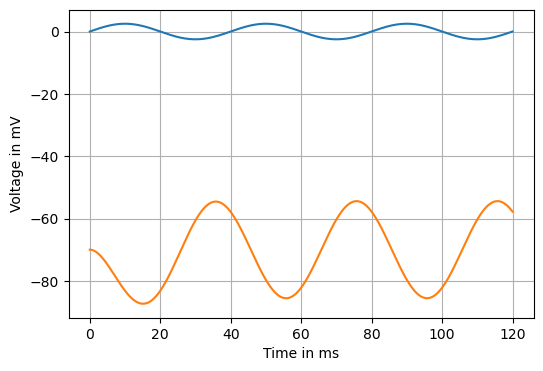

In [218]:
fig,ax = plt.subplots(figsize=(6, 4))

ax.plot(statemon.t/ms, (statemon.I[0]/nA))
ax.plot(statemon.t/ms, (statemon.v[0]/mV))

ax.set_xlabel("Time in ms")
ax.set_ylabel("Voltage in mV")
# ax.legend(loc = 'lower right')

ax.grid()

plt.show()

In [246]:
approx_amp = ((statemon.v[0]/mV).max() - (statemon.v[0]/mV).min())/2
nt = len(statemon.t)
corr = signal.correlate(statemon.v[0]/mV, statemon.I[0]/nA)
corr /= max(corr)

ft = 25*Hz*(statemon.t)[np.abs(corr[:nt]) == max(np.abs(corr[:nt]))][0]
ft  ### 2*pi*ft is the phase lag....which is approximately 5*pi which is equivalent to pi

2.5880000000000005

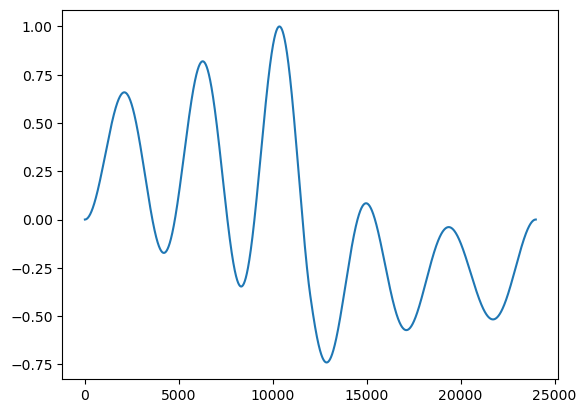

In [243]:
plt.plot(corr)

In [310]:
start_scope()

defaultclock.dt = 0.1*us 

I_amp = 2.5*nA
I_0 = 0*nA

duration = 120*ms

n = 7
eqs = '''
dv/dt = - (v - v_rest + R*I)/tau_m : volt
freq : Hz
I = I_amp*sin(2*pi*freq*t) : amp
''' 
group = NeuronGroup(n, eqs, method="euler")
statemon = StateMonitor(group, ['v', 'I'], record=True)
group.v = v_rest 
group.freq = [10*Hz, 50*Hz, 100*Hz, 500*Hz, 1000*Hz, 5000*Hz, 10000*Hz]

run(duration)

WARNING    'freq' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 10. * khertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [311]:
len(statemon.t)

1200000

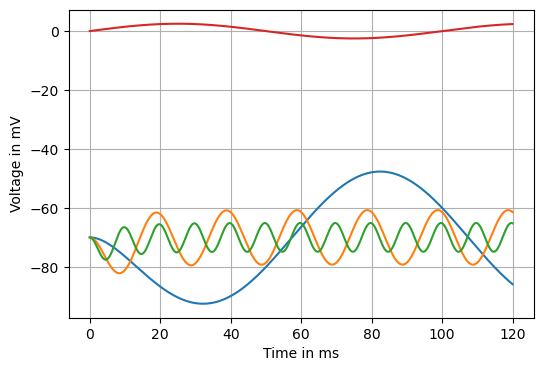

In [335]:
fig,ax = plt.subplots(figsize=(6, 4))

ax.plot(statemon.t/ms, (statemon.v[0]/mV) )
ax.plot(statemon.t/ms, (statemon.v[1]/mV) )
ax.plot(statemon.t/ms, (statemon.v[2]/mV) )

ax.plot(statemon.t/ms, (statemon.I[0]/nA) )

ax.set_xlabel("Time in ms")
ax.set_ylabel("Voltage in mV")

ax.grid()

plt.show()

Text(0, 0.5, 'Amp in mV')

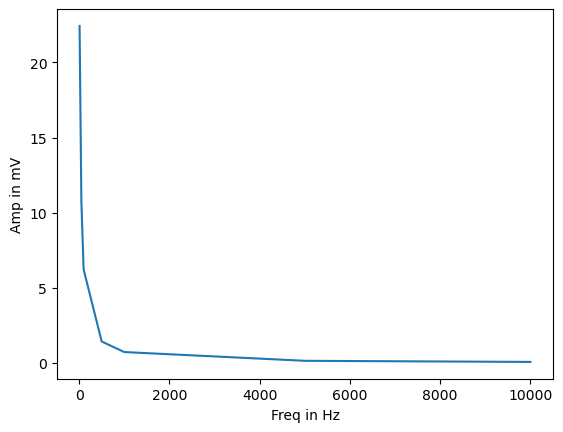

In [313]:
approx_amp = [((statemon.v[i]/mV).max() - (statemon.v[i]/mV).min())/2 for i in range(n)]

plt.plot(group.freq/Hz, approx_amp)
plt.xlabel("Freq in Hz")
plt.ylabel("Amp in mV")

In [277]:
#### This is like a low-pass filter - high amplitude for small freq, almost nothing for high freq

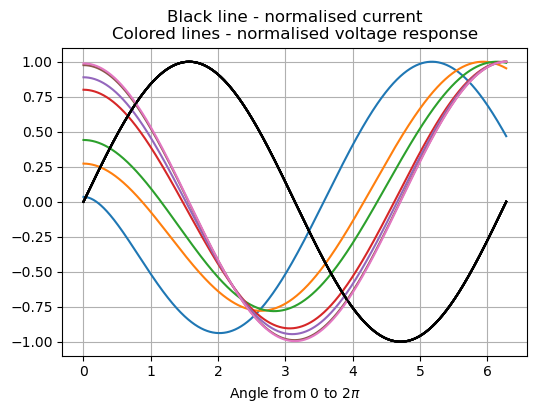

In [343]:
fig,ax = plt.subplots(figsize=(6, 4))

for i in range(n):
    freq = group.freq[i]
    T_max = 1/freq
    # print(freq, T_max)
    t_allowed = (statemon.t)[statemon.t <= T_max]
    angle = 2*np.pi*freq*t_allowed
    # print(angle)

    n_angle = len(angle)

    v_allowed = (statemon.v[i]/mV)[:n_angle]
    v_norm = (v_allowed - np.mean(v_allowed))
    v_norm /= np.max(v_norm) 

    I_allowed = (statemon.I[i]/nA)[:n_angle]
    I_norm = (I_allowed - np.mean(I_allowed)) 
    I_norm /= np.max(I_norm)

    ax.plot(angle, v_norm)
    ax.plot(angle, I_norm, color = "k")
    # ax.plot(statemon.t/ms, (statemon.I[0]/nA) / max(statemon.I[0]/nA) )

ax.set_xlabel(r"Angle from 0 to 2$\pi$")
# ax.set_ylabel("Voltage in mV")

ax.grid()

ax.set_title("Black line - normalised current\nColored lines - normalised voltage response")

plt.show()

In [342]:
### Phase angle changes from nearly pi to pi/2 